In [1]:
from tinydb import TinyDB, Query

event_logs = {}
%store -r event_logs
print(event_logs[0])

ADAPTATIONS = []
%store -r ADAPTATIONS
print(ADAPTATIONS)

PATH_TO_DB = ''
%store -r PATH_TO_DB
db = TinyDB(PATH_TO_DB)

{'trace_id': 0, 'events': [{'name': 'Process Start Event', 'start_time': datetime.datetime(2022, 8, 1, 9, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 9, 0, tzinfo=datetime.timezone.utc), 'resource': None, 'cost': 0}, {'name': 'A', 'start_time': datetime.datetime(2022, 8, 1, 9, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 10, 0, tzinfo=datetime.timezone.utc), 'resource': 'Default Resource-000001', 'cost': 20.0}, {'name': 'B', 'start_time': datetime.datetime(2022, 8, 1, 10, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 11, 0, tzinfo=datetime.timezone.utc), 'resource': 'Default Resource-000003', 'cost': 20.0}, {'name': 'C', 'start_time': datetime.datetime(2022, 8, 1, 11, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 12, 0, tzinfo=datetime.timezone.utc), 'resource': 'Default Resource-000003', 'cost': 20.0}, {'name': 'Process End Event', 'start_time': datetime.datetime(

In [2]:
from statistics import mean
import math

def recommend_adaptation_action(kpi_threshold, trace_log, is_time_optimization, prediction_method='perfect'):
    estimated_cycle_time = estimate_cycle_time(event_logs, trace_log, method=prediction_method)

    adapted_cycle_time_estimation = 0
    
    if is_time_optimization and estimated_cycle_time < kpi_threshold: # no violation
        best_adaptation = None
    else:
        # violation: adaptation needed
        best_adaptation, adapted_cycle_time_estimation = get_best_adaptation(kpi_threshold, estimated_cycle_time, trace_log, is_time_optimization)

    time_difference_closest_adapted_and_adapted_estimation, time_difference_closest_adapted_and_this = calculate_time_difference_to_closest_adapted(event_logs, trace_log, adapted_cycle_time_estimation)
    

    store_adaptation_in_db(kpi_threshold, prediction_method, estimated_cycle_time, trace_log, is_time_optimization, best_adaptation, time_difference_closest_adapted_and_adapted_estimation, time_difference_closest_adapted_and_this)
    
    return best_adaptation
    
def get_best_adaptation(kpi_threshold, estimated_cycle_time, trace_log, is_time_optimization):
    best_cycle_time_change = 0
    if not is_time_optimization:
        best_cycle_time_change = math.inf
    
    best_adaptation = None
    
    # get best adaptation: minimum addition to or maximum reduction from cycle time
    for adaptation in ['skip-activity']:
        adaptation_cycle_time_change = get_adaptation_cycle_time_change(adaptation, trace_log) # negative value for reductions
        
        if adaptation_cycle_time_change < best_cycle_time_change:
            # if better than last available adaptation (default is no adaptation)
            best_cycle_time_change = adaptation_cycle_time_change
            best_adaptation = adaptation
            
    
    adapted_cycle_time_estimation = estimated_cycle_time + best_cycle_time_change
    
    if (is_time_optimization and adapted_cycle_time_estimation < kpi_threshold) \
        or not is_time_optimization:
        return best_adaptation, adapted_cycle_time_estimation
    
    return None, 0

def calculate_time_difference_to_closest_adapted(event_logs, trace_log, adapted_cycle_time_estimation):
    trace_id = trace_log['trace_id']
    trace_duration = get_trace_duration(trace_log)
    
    pointer_prev = trace_id
    
    while pointer_prev > 0 and event_logs[pointer_prev]['adapted'] == False:
        pointer_prev-=1
    
    closest_prev_adapted_cycle_time = get_trace_duration(event_logs[pointer_prev])

    pointer_next = trace_id
    
    while pointer_next < len(event_logs) and event_logs[pointer_next]['adapted'] == False:
        pointer_next+=1
    
    closest_next_adapted_cycle_time = get_trace_duration(event_logs[pointer_next])

    average_next_prev_cycle_time = (closest_prev_adapted_cycle_time + closest_next_adapted_cycle_time) / 2

    return abs(average_next_prev_cycle_time - adapted_cycle_time_estimation), abs(average_next_prev_cycle_time - trace_duration) if not trace_log['adapted'] else 0
        
    
def get_adaptation_cycle_time_change(adaptation, trace):
    # we assume adaptations and their impact value are already available
    # a map of trace variants to time reduction/addition value
    trace_id = trace['trace_id']
    adaptation_impact = get_adaptation_impact(adaptation, trace_id) 
    
    return adaptation_impact

def get_adaptation_impact(adaptation, trace_id):
    Adaptation_Impact = Query() 
    impact = db.search((Adaptation_Impact.up_to_trace_id == trace_id) & (Adaptation_Impact.adaptation_type == adaptation))
    if (len(impact) != 1):
        print('get_adaptation_impact: Not a Single row returned as adaptation impact!')
        return 0
    return impact[0]['adaptation_effect_time']
    
def estimate_cycle_time(event_logs, trace_log, method='average'):

    estimation_cycle_time = 0

    if method == 'average':
        # a trace is similar if it starts with this partial trace
        estimation_cycle_time = get_average_similar_traces(event_logs, trace_log)
    elif method == 'perfect':
        estimation_cycle_time = get_trace_duration(trace_log)
    
    # alternatively: 1) a perfect estimation with some marginal error or 2) Nirdizati regression estimator could be used
    return estimation_cycle_time

def get_average_similar_traces(event_logs, trace_log):
    durations_similar = []

    for past_trace in event_logs:
        duration = get_trace_duration(past_trace)
        if is_trace_similar(past_trace, trace_log):
            durations_similar.append(duration)

    average_durations = mean(durations_similar)
    return average_durations

def get_trace_duration(trace):
    events = trace['events']
    duration = (events[-1]['end_time'] - events[0]['start_time']).total_seconds()
    return duration

def remove_until_checkpoint(trace, adaptation_checkpoint):
    last_event = trace['events'][-1]

    while last_event is not None and last_event['name'] not in adaptation_checkpoint:
        trace['events'].pop()
        last_event = trace['events'][-1]

    
def is_trace_similar(trace_original, trace_partial):

    trace_original_activities = get_activities_list(trace_original)
    trace_partial_activities = get_activities_list(trace_partial)

    if len(trace_original_activities) < len(trace_partial_activities):
        return False

    for index, activity in enumerate(trace_partial_activities):
        if activity != trace_original_activities[index]:
            return False

    return True

def get_activities_list(trace):
    events = trace['events']
    activities = []
    for event in events:
        activities.append(event['name'])
    
    return activities

def measure_estimation_accuracy(trace_completed, estimation_seconds):
    
    duration = get_trace_duration(trace_completed)
    error = abs(duration - estimation_seconds)
    APE = float(error/duration) * 100

    return APE

def measure_mean_absolute_percentage_error(event_logs, estimation_method=None):
    APEs = []
    for trace in event_logs:
        estimation_cycle_time = estimate_cycle_time(event_logs, trace, method=estimation_method)
        absolute_percentage_error = measure_estimation_accuracy(trace, estimation_cycle_time)
        APEs.append(absolute_percentage_error)

    return mean(APEs), APEs

def store_adaptation_in_db(kpi_threshold, prediction_method, estimated_cycle_time, trace_log, is_time_optimization, recommended_adaptation, time_difference_closest_adapted_and_adapted_estimation, time_difference_closest_adapted_and_this):
    adaptation_table = db.table('adaptations')
    trace_activities = get_activities_list(trace_log)
    adaptation_table.insert({'kpi_threshold':kpi_threshold, 'prediction_method':prediction_method, 'estimated_cycle_time':estimated_cycle_time, \
    'trace_activities':trace_activities, 'is_time_optimization':is_time_optimization, 'recommended_adaptation':recommended_adaptation, \
    'time_difference_closest_adapted_and_adapted_estimation':time_difference_closest_adapted_and_adapted_estimation, 'time_difference_closest_adapted_and_this':time_difference_closest_adapted_and_this})


### Plot cycle time prediction error using an estimation method

MAPE method: average: 0.0


[Text(0.5, 1.0, 'Absolute Percentage Error Frequency Histogram'),
 Text(0, 0.5, 'Trace Frequency'),
 Text(0.5, 0, 'Absolute Percentage Error')]

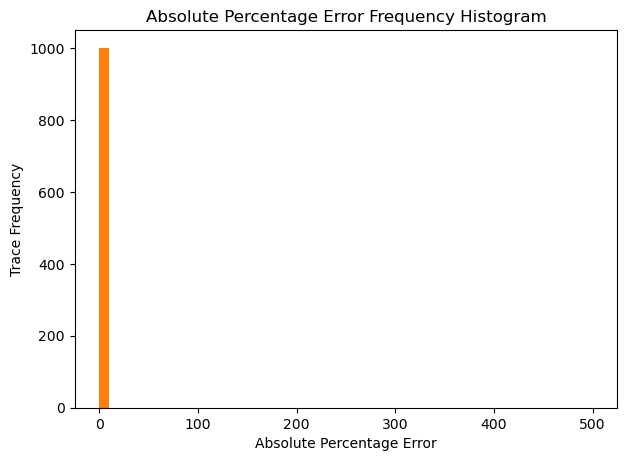

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import copy

MAPE, APEs = measure_mean_absolute_percentage_error(event_logs, estimation_method='perfect')
print('MAPE method: average:', MAPE)

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = APEs
plt.hist(x, bins=50, range=[0, 500])
plt.hist(x, bins=5, range=[0, 50])
plt.gca().set(title='Absolute Percentage Error Frequency Histogram', ylabel='Trace Frequency', xlabel='Absolute Percentage Error')


In [4]:
db.drop_table('adaptations')

for trace in event_logs:
    recommend_adaptation_action(80000, trace, is_time_optimization=True, prediction_method='perfect')